# Answers!

## Task! Get some data

In the next section we'll be creating a validation test. So let's started by reading in some data! With the filters detect_isPrimary, refExtendedness==1, get the following quantities using the g band:

* From the DP0.2 schema look for the PSF shapes (use PSF rather than DebiasedPSF)
* Look for the equivalent shape moments
* Compute the trace of the PSF (ixx + iyy)
* Compute the trace of the HSM moments
* Compute the complex ellipticity for both the HSM and PSF moments (eq 7.5 of https://arxiv.org/pdf/2011.03409) 
* Look for cModel magnitudes, and read in the g band magnitudes (you'll need to convert from fluxes)
* Get RA/ DEC

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
sys.path.insert(0,'/global/cfs/projectdirs/lsst/groups/SRV/gcr-catalogs-test')
import GCRCatalogs

%matplotlib inline


In [64]:
catalog = GCRCatalogs.load_catalog('lsst_object')

I'm going to cheat a little from inspecting the schema, but here are the quantities we're looking for!

In [65]:
quantity_list = sorted(catalog.list_all_native_quantities())
for i in range(len(quantity_list)):
    q = quantity_list[i]
    info = catalog.get_quantity_info(q)
    if ('g_' in q) and ('PSF' in q) and 'Debiased' not in q:
        print(q)



g_iPSF_flag
g_ixxPSF
g_ixyPSF
g_iyyPSF


Looks like we need to add the flag too! On top of this let's add the normal HSM quantities, it looks like these are 'g_ixx' etc:

In [66]:
quantity_list = sorted(catalog.list_all_native_quantities())
for i in range(len(quantity_list)):
    q = quantity_list[i]
    info = catalog.get_quantity_info(q)
    if ('g_' in q) and 'ixx' in q:
        print(q)


g_ixx
g_ixxDebiasedPSF
g_ixxPSF
g_ixxRound


Now we need the cModel magnitudes

In [67]:
quantity_list = sorted(catalog.list_all_native_quantities())
for i in range(len(quantity_list)):
    q = quantity_list[i]
    info = catalog.get_quantity_info(q)
    if ('g_' in q) and ('cModel' in q):
        print(q)


g_cModelFlux
g_cModelFluxErr
g_cModelFlux_inner
g_cModel_flag
g_cModel_flag_apCorr
g_free_cModelFlux
g_free_cModelFluxErr
g_free_cModelFlux_flag
g_free_cModelFlux_inner
i_cModel_flag_apCorr
r_cModel_flag_apCorr
u_cModel_flag_apCorr
y_cModel_flag_apCorr
z_cModel_flag_apCorr


Now let's get our functions:


In [68]:
def trace(ixx,ixy,iyy):
    return (ixx+iyy)

def e(ixx,ixy,iyy):
    ixx = np.complex128(ixx)
    ixy = np.complex128(ixy)
    iyy = np.complex128(iyy)
    denom = (ixx+iyy + 2.*np.sqrt(ixx*iyy-ixy**2))
    e = (ixx-iyy+2*ixy*1j)/denom
    return e

# borrowed from GCRCatalogs, can get this as from GCRCatalogs.dc2dm_catalog import convert_nanoJansky_to_mag
def convert_nanoJansky_to_mag(flux):
    """Convert calibrated nanoJansky flux to AB mag.
    """
    AB_mag_zp_wrt_Jansky = 8.90  # Definition of AB
    # 9 is from nano=10**(-9)
    AB_mag_zp_wrt_nanoJansky = 2.5 * 9 + AB_mag_zp_wrt_Jansky

    return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


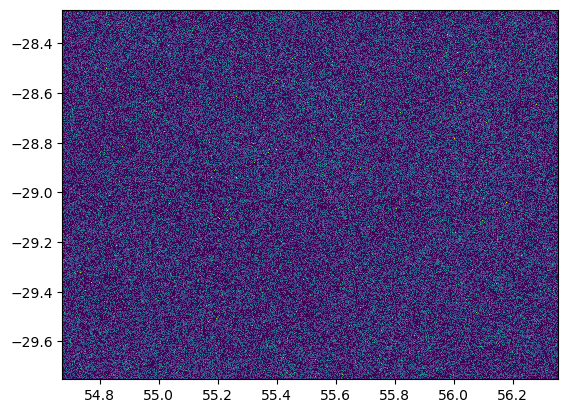

In [86]:
quantities = ["g_ra","g_decl","g_ixxPSF", "g_ixyPSF", "g_iyyPSF","g_cModelFlux"]
filters = ['detect_isPrimary','g_extendedness==1', 'g_iPSF_flag==False', 'g_cModel_flag==False']
data = catalog.get_quantities(quantities, filters =filters)  

plt.figure()
plt.hist2d(data["g_ra"],data["g_decl"],bins=1000)
plt.show()

In [89]:
#add the extra quantities
data['T_PSF'] = trace(data['g_ixxPSF'],data['g_ixyPSF'],data['g_iyyPSF'])
data['ePSF'] = e(data['g_ixxPSF'],data['g_ixyPSF'],data['g_iyyPSF'])
data['g_mag'] = convert_nanoJansky_to_mag(data['g_cModelFlux'])

/tmp/ipykernel_1243021/3349256481.py:20: RuntimeWarning: invalid value encountered in log10
  return -2.5 * np.log10(flux) + AB_mag_zp_wrt_nanoJansky


Let's check it looks okay!

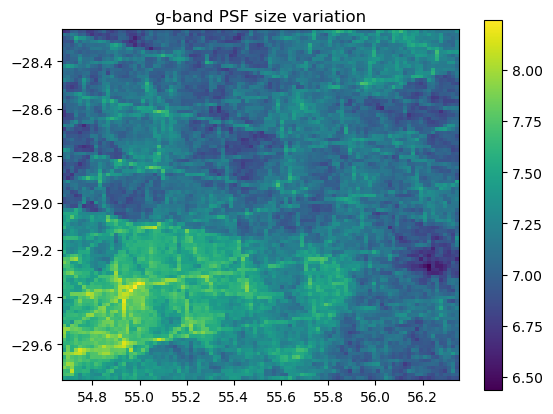

In [90]:
from scipy.stats import binned_statistic_2d as bs2d
plt.title('g-band PSF size variation')
val, xedge, yedge, bincount = bs2d(data["g_ra"],data["g_decl"],data['T_PSF'],statistic='median',bins=100)
plt.imshow(val,extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]])
plt.colorbar()
plt.show()
